In [1]:
import json, requests, os, time, scipy
import pandas as pd
import matplotlib.pyplot as plt
from typing import Any, Dict
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
import cobra

import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader

from dGbyG.config import *
from dGbyG.utils.constants import *
from dGbyG.utils.ChemFunc import *
from dGbyG.utils.custom_tools import rapid_process_result, rapid_linear_reg
from dGbyG.utils.NNFunc import mol_to_graph_data
from dGbyG.Chemistry import Reaction
from dGbyG.network.GNNetwork import MP_network
from dGbyG.network.Dataset import Train_Dataset
from dGbyG.network.trainer import Model
from dGbyG.api import Compound, predict_standard_dGf_prime, predict_standard_dGr_prime, predict_standard_dGr_prime_from_S, Reaction
from dGbyG.api.utils import network

In [7]:
comp = Compound('C0000', input_type='kegg')

In [8]:
comp.mol

In [2]:
recon3d = cobra.io.load_matlab_model('../data/Recon3D/Recon3D_301.mat')
S = cobra.util.array.create_stoichiometric_matrix(recon3d) # shape = [met, rxn]

# patch
recon3d.metabolites.get_by_id('aqcobal[e]').annotation['pubchem.compound'] = ['4238']
recon3d.metabolites.get_by_id('aqcobal[c]').annotation['pubchem.compound'] = ['4238']
recon3d.metabolites.get_by_id('yvite[e]').annotation['kegg.compound'] = ['C02483']

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-29


No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


In [26]:
ID_types = set()
met_ids = set()
for met in recon3d.metabolites:
    met_ids.add(met.id[:-3])
    for key, value in met.annotation.items():
        assert len(value) == 1
        ID_types.add(key)
ID_types

{'SMILES', 'chebi', 'hmdb', 'inchi', 'kegg.compound', 'pubchem.compound'}

In [27]:
mets_df = pd.DataFrame(columns=list(ID_types), index=list(met_ids))
for met in recon3d.metabolites:
    mets_df.loc[met.id[:-3], 'recon3d'] = met.id[:-3]
    for key, value in met.annotation.items():
        if pd.isna(mets_df.loc[met.id[:-3], key]):
            mets_df.loc[met.id[:-3], key] = value[0]
        else:
            assert mets_df.loc[met.id[:-3], key] == str(value[0])
mets_df.rename(columns={'kegg.compound':'kegg'}, inplace=True)
mets_df = mets_df.loc[:,['inchi', 'kegg', 'recon3d', 'SMILES', 'chebi', 'hmdb', ]]

In [28]:
l = []
for i, id in enumerate(mets_df.index):
    row = mets_df.loc[id, :]
    mol = None
    f_mol = None
    for cid_type, cid in row.items():
        if pd.notna(cid):
            mol = to_mol(cid=cid, cid_type=cid_type)
        if mol:
            break
    
    for f_cid_type, f_cid in row.items():
        if pd.notna(f_cid):
            f_mol = to_mol(cid=f_cid, cid_type=f_cid_type, sanitize=False, Hs=None)
        if f_mol:
            break

    if (mol is None) and (f_mol is None):
        l.append('no structure')
    elif (mol is None) and (f_mol is not None):
        print(id)
        l.append('false structure')
    elif (mol is not None) and (f_mol is not None):
        l.append('true structure')
    else:
        print(id, mol, f_mol)
        break
        pass

l = np.array(l)
(l=='no structure').sum(), (l=='false structure').sum(), (l=='true structure').sum()

pchol2ste_hs
CE6252
CE2120


(686, 3, 3451)

In [3]:
met = recon3d.metabolites.get_by_id('CE6252[c]')
met

Metabolite identifier,CE6252[c]
Name,Urate Radical
Memory address,0x7965821c0b60
Formula,C5H3N4O3
Compartment,c
In 3 reaction(s),"RE2605C, HMR_6607, RE2591C"


In [4]:
met.annotation

{'SMILES': ['[H]OC1=NC2=C(N=[C](O[H])=N2)C(O[H])=N1'],
 'inchi': ['InChI=1S/C5H3N4O3/c10-3-1-2(7-4(11)6-1)8-5(12)9-3/h(H3,6,7,8,9,10,11,12)']}

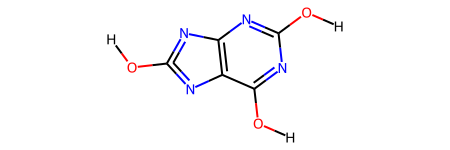

In [5]:
Chem.MolFromSmiles(met.annotation['SMILES'][0], sanitize=False)

In [10]:
met = recon3d.metabolites.get_by_id('pchol2ste_hs[c]')
print(met.annotation['SMILES'][0])
met

[H]OC([H])(C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])OP(=O)(O[H])OC([H])([H])C([H])([H])[N](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H]


Metabolite identifier,pchol2ste_hs[c]
Name,2-Stearoylglycerophosphocholine
Memory address,0x796581747c80
Formula,C26H55NO7P
Compartment,c
In 3 reaction(s),"PCHOL2STE_HSPLA2, PCHOL2STE_HSABCt, PCHOL2STE_HSt1e"


In [11]:
met = recon3d.metabolites.get_by_id('CE2120[c]')
print(met.annotation['SMILES'][0])
met

[O-]S([O-])(=O)=O.[H]Oc1c([H])c2nc([H])c(c2c([H])c1OC([H])([H])[H])C([H])([H])C([H])([H])N([H])C(=O)C([H])([H])[H]


Metabolite identifier,CE2120[c]
Name,6-Hydroxymelatonin-Sulfate
Memory address,0x796580d71970
Formula,X
Compartment,c
In 1 reaction(s),HMR_4549


Human1

In [2]:
Human_GEM_path = "../Human-GEM"

# Read model and patch it
human1 = cobra.io.read_sbml_model(os.path.join(Human_GEM_path, "model/Human-GEM.xml"))
human1.metabolites.get_by_id('MAM01935e').annotation['kegg.compound'] = 'C02483'

metabolites_df = pd.read_csv(os.path.join(Human_GEM_path, "model/metabolites.tsv"), sep='\t')
reactions_df = pd.read_csv(os.path.join(Human_GEM_path, "model/reactions.tsv"), sep='\t')

rxns_df = reactions_df.set_index('rxns', inplace=False)
mets_df = metabolites_df.set_index('mets', inplace=False)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-29


In [3]:
ID_types = set()
met_ids = set()
for met in human1.metabolites:
    met_ids.add(met.id[:-3])
    for key, value in met.annotation.items():
        ID_types.add(key)
ID_types

{'bigg.metabolite',
 'chebi',
 'hmdb',
 'inchi',
 'kegg.compound',
 'lipidmaps',
 'metanetx.chemical',
 'pubchem.compound',
 'sbo',
 'vmhmetabolite'}

In [24]:
l = {}
# obtain a list of compound objects using `get_compound`
for met in human1.metabolites:
    kegg = met.annotation.get('kegg.compound')
    chebi = met.annotation.get('chebi')
    hmdb = met.annotation.get('hmdb')
    recon3d_id = mets_df.loc[met.id,'metRecon3DID'] if pd.notna(mets_df.loc[met.id,'metRecon3DID']) else None
    metanetx = met.annotation.get('metanetx.chemical')
    lipidmaps = met.annotation.get('lipidmaps')
    inchi = met.annotation.get('inchi')

    row = {'inchi': inchi, 'kegg': kegg, 'recon3d': recon3d_id, 'chebi': chebi, 
           'hmdb': hmdb, 'metanetx': metanetx, 'lipidmaps': lipidmaps, }
    
    mol = None
    for cid_type, cid in row.items():
        if cid is not None:
            cid = [cid] if type(cid)==str else cid
            for cidx in cid:
                mol = to_mol(cid=cidx, cid_type=cid_type)
                if mol:
                    break
        if mol:
            break
    
    f_mol = None
    for f_cid_type, f_cid in row.items():
        if f_cid is not None:
            f_cid = [f_cid] if type(f_cid)==str else f_cid
            for f_cidx in f_cid:
                f_mol = to_mol(cid=f_cidx, cid_type=f_cid_type)
                if f_mol:
                    break
        if f_mol:
            break

    if (mol is None) and (f_mol is None):
        l[met.id[:-1]]='no structure'
    elif (mol is None) and (f_mol is not None):
        l[met.id[:-1]]=('false structure')
    elif (mol is not None) and (f_mol is not None):
        l[met.id[:-1]]=('true structure')
    else:
        print(id, mol, f_mol)
        break
        pass

l = np.array(list(l.values()))
(l=='no structure').sum(), (l=='false structure').sum(), (l=='true structure').sum()

(642, 0, 3514)